In [90]:
!pip install -q --upgrade \
  numpy scipy librosa jams scikit-learn audioread torch torchaudio

# Match google-colab’s pins (optional)
!pip install -q pandas==2.2.2 requests==2.32.3


In [1]:
# imports

import numpy as np
import librosa
import jams
import sklearn
import torch
import torchaudio

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set Paths
import os, shutil, zipfile, urllib.request

ROOT = "/content/drive/MyDrive/ChordProject"
GS_ROOT = f"{ROOT}/GuitarSet"                     # final dataset root
# AUDIO_DIR = f"{GS_ROOT}/audio_mix"                # expected by our loader
AUDIO_DIR = f"{GS_ROOT}/audio_mic"                # expected by our loader
ANN_DIR   = f"{GS_ROOT}/annotations"

TMP_ZIPS  = "/content/gs_zips"
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(ANN_DIR, exist_ok=True)
os.makedirs(TMP_ZIPS, exist_ok=True)



In [ ]:
 # Downloading GuitarSet data to deive

 """
 # Download GuitarSet parts from Zenodo (direct URLs)
files = {
   "annotation.zip":        "https://zenodo.org/record/3371780/files/annotation.zip?download=1",
   "audio_mono-mic.zip":    "https://zenodo.org/record/3371780/files/audio_mono-mic.zip?download=1",
#   # can add other parts later if needed:
   # "audio_mono-pickup_mix.zip": "https://zenodo.org/record/3371780/files/audio_mono-pickup_mix.zip?download=1",
#   # "audio_hex-pickup_original.zip": "https://zenodo.org/record/3371780/files/audio_hex-pickup_original.zip?download=1",
#   # "audio_hex-pickup_debleeded.zip": "https://zenodo.org/record/3371780/files/audio_hex-pickup_debleeded.zip?download=1",
 }
def download(url, dst):
     if not os.path.exists(dst):
         print("Downloading", os.path.basename(dst))
         urllib.request.urlretrieve(url, dst)
     else:
         print("Already present:", os.path.basename(dst))

for fname, url in files.items():
     download(url, os.path.join(TMP_ZIPS, fname))


# Unzip into Drive
import zipfile, os, shutil

def unzip_to(src_zip, dst_dir):
     with zipfile.ZipFile(src_zip, 'r') as z:
         z.extractall(dst_dir)

unzip_to(os.path.join(TMP_ZIPS, "annotation.zip"), GS_ROOT)
unzip_to(os.path.join(TMP_ZIPS, "audio_mono-mic.zip"), GS_ROOT)
# unzip_to(os.path.join(TMP_ZIPS, "audio_mono-pickup_mix.zip"), GS_ROOT)



src_ann = f"{GS_ROOT}/annotations"   # plural
src_audio = f"{GS_ROOT}/audio_mic"   # underscore
# src_audio = f"{GS_ROOT}/audio_mix"   # underscore
src_ann = GS_ROOT
src_audio = GS_ROOT

for f in os.listdir(src_ann):
     if f.endswith(".jams"):
         shutil.copy(os.path.join(src_ann, f), os.path.join(ANN_DIR, f))
for f in os.listdir(src_audio):
     if f.endswith(".wav"):
         shutil.copy(os.path.join(src_audio, f), os.path.join(AUDIO_DIR, f))

         """

'\n# Download GuitarSet parts from Zenodo (direct URLs)\nfiles = {\n  "annotation.zip":        "https://zenodo.org/record/3371780/files/annotation.zip?download=1",\n  "audio_mono-mic.zip":    "https://zenodo.org/record/3371780/files/audio_mono-mic.zip?download=1",\n#   # can add other parts later if you want:\n  # "audio_mono-pickup_mix.zip": "https://zenodo.org/record/3371780/files/audio_mono-pickup_mix.zip?download=1",\n#   # "audio_hex-pickup_original.zip": "https://zenodo.org/record/3371780/files/audio_hex-pickup_original.zip?download=1",\n#   # "audio_hex-pickup_debleeded.zip": "https://zenodo.org/record/3371780/files/audio_hex-pickup_debleeded.zip?download=1",\n}\ndef download(url, dst):\n    if not os.path.exists(dst):\n        print("Downloading", os.path.basename(dst))\n        urllib.request.urlretrieve(url, dst)\n    else:\n        print("Already present:", os.path.basename(dst))\n\nfor fname, url in files.items():\n    download(url, os.path.join(TMP_ZIPS, fname))\n\n\n# Unz

In [4]:
#  Verify Dataset Exists
print(len(os.listdir(AUDIO_DIR)), "audio files - .wav")
print(len(os.listdir(ANN_DIR)), "annotation files - .jams")

360 audio files - .wav
360 annotation files - .jams


In [5]:
import random, numpy as np, torch, os

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True   # slight speed hit, more reproducible
    torch.backends.cudnn.benchmark = False


# Data preparation pipeline for the GuitarSet dataset

In [6]:
import random
import numpy as np
import pandas as pd
import librosa, jams
from sklearn.preprocessing import LabelEncoder

In [7]:
# Parameters for audio resolution
# These set the audio resolution and the augmentation rules (pitch shifting up or down by semitones).

SR = 22050              # target sampling rate for all audio
HOP = 512               # hop length in samples between CQT frames
BINS_PER_OCT = 12       # how many frequency bins per octave
N_BINS = 84             # total bins in the CQT (so 84 / 12 = 7 octaves)
FMIN = None             # will default to C1




augment_settings = dict(
    enable=False, # master switch
    # pitch shift
    use_pitch=False,
    pitch_shift_choices=[-2, -1, 1, 2],  # semitone shifts, remove 0, since 0=identity
    prob=0.25,# 25% chance per song to apply pitch-shift,

    # SpecAugment:
    use_spec=False,
    spec_prob=0.3,
    time_mask_w=12,
    freq_mask_w=6,
)





# Helper functions for Vocabulary


In [8]:
# Chord name helpers
# This is a dictionary for musical notes:
  # Converts flats to sharps (e.g. "Db" → "C#").
  # Keeps an ordered list of pitch classes (notes).
  # Maps pitch class names to indexes.

# Edge cases
# Rare spellings like E# / B# / Cb / Fb (theoretical but appear in some keys).
# Double sharps (F##) or double flats (Gbb).
# robust normalizer that collapses common aliases to the 12-class sharp set:

# canonical sharp PCS

FLAT_TO_SHARP = {"Db":"C#","Eb":"D#","Gb":"F#","Ab":"G#","Bb":"A#"}
PCS = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"] # -> 12 bins -> 12 indices (0..11), every pitch class maps to a single index
PC_TO_INDEX = {pc:i for i,pc in enumerate(PCS)}


ALIASES = {
    "B#":"C", "E#":"F",
    "Cb":"B", "Fb":"E",
    "Db":"C#", "Eb":"D#", "Gb":"F#", "Ab":"G#", "Bb":"A#",
    # optional doubles (map to nearest enharmonic)
    "C##":"D", "D##":"E", "F##":"G", "G##":"A", "A##":"B",
    "E##":"F#", "B##":"C#",
    "Cbb":"Bb","Dbb":"C","Ebb":"D","Fbb":"Eb","Gbb":"F","Abb":"G","Bbb":"A",
}

def canonical_pc(name: str):
    if not name: return None
    n = name.strip().replace("♭","b").replace("♯","#")
    n = ALIASES.get(n, n)
    return n if n in PC_TO_INDEX else None

def shift_pc(name, semis):
    pc = canonical_pc(name)
    if pc is None or pc == "N": return name
    return PCS[(PC_TO_INDEX[pc] + semis) % 12]



In [9]:

# Standardizes a pitch name so all flats are converted to sharps, and weird Unicode ♭/♯ become normal b/#.
def _normalize_pc(pc):
    if pc is None: return None
    pc = pc.strip().replace("♭","b").replace("♯","#")
    return FLAT_TO_SHARP.get(pc, pc)

# Moves a pitch by semis semitones up/down, wrapping around at 12 (mod 12).
# We shift notes by an integer number of semitones (mod 12).
  # Example: _shift_pc("C", 2) → "D".
def _shift_pc(pc, semis):
    if not pc or pc == "N": return pc
    pc = _normalize_pc(pc)
    if pc not in PC_TO_INDEX: return pc
    return PCS[(PC_TO_INDEX[pc] + semis) % 12]


#	Splits a chord label into root note, quality (maj, min, dim, etc.), and optional bass note (after slash /).
# parse → [root][:quality][/bass]
# shift root and (if present) bass by semis semitones
# rebuild the text;
  # The quality string (min, maj7, sus4, dim, 7, etc.) stays identical.
  # Only root (before :) and bass (after /) move by semis.

# if we shift the root note up/down semitones, all chord members shift with it, keeping the chord type the same.

# Example of how a label is parsed
# Take: "G:maj7/B"
# 1.	main, bass = "G:maj7", "B" (split on /)
# 2.	root, qual = "G", "maj7" (split on :)
# 3.	Shift by, say, +4:
      # root G → B
      # bass B → D#
# 4.	Rebuild: f"{root_t}:{qual}/{bass_t}" → B:maj7/D#


def transpose_chord_label(chord, semis):
    c = (chord or "").strip()
    if c in ["N","X",""]: return c
    main, bass = (c.split("/",1)+[None])[:2]
    if bass: bass = bass.strip()
    if ":" in main:
        root, qual = [s.strip() for s in main.split(":",1)]
    else:
        root, qual = main.strip(), ""
    root_t = _shift_pc(root, semis)
    bass_t = _shift_pc(bass, semis) if bass else None
    if qual and bass_t: return f"{root_t}:{qual}/{bass_t}"
    if qual:            return f"{root_t}:{qual}"
    if bass_t:          return f"{root_t}/{bass_t}"
    return root_t

# Takes the entire chord label table for a song and shifts all chords up/down by the same semitones.
def transpose_lab_dataframe(lab_df, semis):
    out = lab_df.copy()
    out["chord"] = out["chord"].apply(lambda c: transpose_chord_label(c, semis))
    return out






# Handling GuitarSet annotations



In [10]:
# Read the .jams file → get a DataFrame of chord segments: start, end, chord.

# Reads .jams file
# Loads that chord namespace - finds the chord annotations (namespace "chord")
# Picks "performed" layer (real played chords) (2nd chord layer if available) if available.

# Returns a pandas DataFrame with:
# start time (sec)
# end time (sec)
# chord label (string)

def jams_to_lab_df(jams_path, chord_layer="performed"):
    """Return DataFrame(start,end,chord). 'performed' picks the 2nd chord layer if present, else 1st."""
    jam = jams.load(jams_path)
    chord_anns = [ann for ann in jam.annotations if ann.namespace == "chord"]
    if not chord_anns:
        raise RuntimeError(f"No chord namespace in {jams_path}")
    # Heuristic: [0]=leadsheet, [1]=performed
    ann = chord_anns[1] if (chord_layer=="performed" and len(chord_anns) > 1) else chord_anns[0]
    rows = []
    for obs in ann.data:
        start = float(obs.time)
        end = float(obs.time + obs.duration)
        label = str(obs.value) if obs.value is not None else "N"
        rows.append((start, end, label))
    return pd.DataFrame(rows, columns=["start","end","chord"]).sort_values("start").reset_index(drop=True)

# The Constant-Q Transform (CQT)


In [11]:
# Making features from audio

# Load the .wav, compute CQT → C_db with shape (n_bins, n_frames).

# Computes Constant-Q Transform (CQT):
  # A spectrogram with logarithmic frequency bins, ideal for music.
  # Converts magnitudes to decibels (amplitude_to_db).
  # Shape: (n_bins, n_frames)

  # Bin = one frequency range in the transform. Each bin corresponds to a note (or a fraction of a note if we set more bins per octave).
    # First bin might be C1 (~32.7 Hz). Second bin = C#1 (~34.6 Hz). Third = D1 (~36.7 Hz)	… continues up to B7 (~7902 Hz) if we have 84 bins.

def compute_cqt(y, sr=SR, hop=HOP, n_bins=N_BINS, bins_per_oct=BINS_PER_OCT, fmin=None):
    if fmin is None:
        fmin = librosa.note_to_hz("C1")
    C =  librosa.cqt(y=y, sr=sr, hop_length=hop, fmin=fmin,
                    n_bins=n_bins, bins_per_octave=bins_per_oct)
    # BINS_PER_OCT = how many steps we divide an octave into.
    #	12 bins/octave = 1 bin per semitone.
    #	If N_BINS = 84 and BINS_PER_OCT = 12, that’s 7 octaves.
    return librosa.amplitude_to_db(np.abs(C), ref=np.max)

In [12]:
# Convert the chord intervals to a framewise label sequence of length n_frames.

# Makes one chord label per spectrogram frame (converts those chord intervals into one label per frame):
  # Loops through frame times.
  # For each frame, finds which chord is active.
  # Returns list of chord strings aligned with each CQT column.

def align_labels_to_frames(lab_df, n_frames, sr=SR, hop=HOP):
    frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=hop)
    labels, idx = [], 0
    for t in frame_times:
        while idx < len(lab_df) and lab_df.loc[idx,"end"] <= t:
            idx += 1
        if idx < len(lab_df) and (lab_df.loc[idx,"start"] <= t < lab_df.loc[idx,"end"]):
            labels.append(lab_df.loc[idx,"chord"])
        else:
            labels.append("N")
    return labels



# Building the vocabulary and vocabulary modes helpers

In [13]:
# vocab modes
def drop_bass(label: str) -> str:
    if not label or label in ("N", "X"):
        return label
    return label.split("/", 1)[0] # keep "root[:quality]"



In [14]:

# collapse to maj/min -This is a deliberately simple collapse that’s very common as a baseline: 12 major + 12 minor + N = 25 classes.
# Matches how MIREX and many papers evaluate (they often report maj/min accuracy separately).

# Results :
# Vocabulary shrinks to 25 classes: 12 major, 12 minor, plus N.

def to_majmin(label: str) -> str:
    """
    Collapse any chord label to MIREX-style maj/min (+N) classes.
    Assumes you've already normalized bare majors: "A" -> "A:maj".
    Rules:
      - N or X -> N
      - root:min / root:m / any label containing 'min' -> root:min
      - dim / ° -> root:min
      - maj or no-minor markers (aug/sus/5/7/9/11/13/etc) -> root (major)
    """
    if not label or label in ("N", "X"):
        return "N"

    # drop slash-bass
    core = label.split("/",1)[0]

    # split into root + quality (if any)
    root, qual = (core.split(":",1)+[""])[:2]
    qual = qual.lower().strip()

    # mapping rules
    if "min" in qual or qual == "m":
        return f"{root}:min"

    # diminished → minor
    if "dim" in qual or "°" in qual:
        return f"{root}:min"

    # augmented, sus, 5 → treat as major (closer flavor)
    if "aug" in qual or "sus" in qual or qual == "5":
        return root

    # 7ths and extensions → decide based on major/minor flavor
    if "maj" in qual or "7" in qual or "9" in qual or "11" in qual or "13" in qual:
        return root  # assume major unless explicitly "min7"

    # fallback: assume major
    return root



# Minor detection: catches min, m, min7, min(add9), etc. → → root:min.
# Diminished (dim, °): maps to minor (closer to its feel).
# Augmented/sus/power chords: map to major (they lack the minor third).
# 7ths/extensions: if not explicitly minor, we call them major.
# Default: anything unrecognized goes to major.


In [15]:
# all those bare "A", "B", "C#" in your class list are majors in disguise.
# it’s better to normalize them explicitly to "root:maj"

def normalize_major(label: str) -> str:
    if not label or label in ("N", "X"):
        return label
    core = label.split("/", 1)[0]
    if ":" not in core:   # no quality → assume major
        root = core.strip()
        return f"{root}:maj"
    return label


In [16]:
# we want our loader to try a few common filename patterns before skipping and missing out files because of naming

import os, glob

def find_audio_path(audio_dir, stem):
    """
    Try to locate the WAV for a given JAMS stem.
    We try common GuitarSet suffixes before giving up.
    """
    candidates = [
        f"{stem}.wav",
        f"{stem}_mic.wav",
        f"{stem}_mix.wav",
    ]
    for name in candidates:
        p = os.path.join(audio_dir, name)
        if os.path.exists(p):
            return p

    # Fallback: any wav that starts with the stem
    hits = glob.glob(os.path.join(audio_dir, f"{stem}*.wav"))
    return hits[0] if hits else None


In [17]:
def idx_by_songs(song_set, aug="orig"):
    if aug == "all":
        return [i for i,m in enumerate(meta) if m["song"] in song_set]
    if isinstance(aug, (tuple,list)):
        return [i for i,m in enumerate(meta) if m["song"] in song_set and m["aug"] in aug]
    return [i for i,m in enumerate(meta) if m["song"] in song_set and m["aug"] == aug]


# Augmentations

In [18]:
# Transposes both audio and chord strings so they still match
# Randomly applies pitch shift augmentation to both:
  # Audio (librosa.effects.pitch_shift).
  # Labels (so chords still match after shifting).
  # Returns (audio, labels, shift_amount).

def maybe_pitch_shift(y, sr, lab_df, aug_cfg):
    if not aug_cfg.get("enable", False): return y, lab_df, 0
    if random.random() > aug_cfg.get("prob", 0.0): return y, lab_df, 0
    semis = random.choice(aug_cfg.get("pitch_shift_choices",[0]))
    if semis == 0: return y, lab_df, 0
    y_ps = librosa.effects.pitch_shift(y, sr=sr, n_steps=semis)
    lab_ps = transpose_lab_dataframe(lab_df, semis)
    return y_ps, lab_ps, semis

In [19]:

import numpy as np

def time_mask(C, max_width=12):
    C = C.copy()
    T = C.shape[1]
    w = np.random.randint(1, max_width+1)
    t0 = np.random.randint(0, max(1, T-w))
    C[:, t0:t0+w] = C[:, t0:t0+w].min()
    return C

def freq_mask(C, max_width=6):
    C = C.copy()
    F = C.shape[0]
    w = np.random.randint(1, max_width+1)
    f0 = np.random.randint(0, max(1, F-w))
    C[f0:f0+w, :] = C[f0:f0+w, :].min()
    return C


# Data Loader

In [20]:

# main loader


# 1. Scan all .jams to build the label vocabulary (LabelEncoder - build a consistent vocabulary (string ↔ integer ID)).

# 2. For each song:
  # Load annotations (lab_df).
  # Load audio waveform (y).
  # Compute CQT and aligned labels (original).
  # Append to X_list, Y_list, meta.

# 3. If augmentation is enabled:
  # Pitch shift both audio + labels.
  # Compute augmented CQT + labels.
  # Add to dataset.

# Return:
  # X_list = list of CQT arrays.
  # Y_list = list of integer-encoded chord sequences.
  # label_enc = encoder to go from chord name ↔ index.
  # meta = info about each item (song name, augmentation type, shift).

def load_guitarset_cqt(
    audio_dir=AUDIO_DIR, ann_dir=ANN_DIR, augment_cfg=augment_settings,
    chord_layer="performed", vocab_mode="full"
):
    """
    vocab_mode: "full" | "no_bass" | "majmin"
    Creates separate items for:
      - orig (always)
      - spec (optional, CQT time/freq masks)  -> aug="spec"
      - pitch_shift (optional)                -> aug="pitch_shift"
    """
    import random
    import numpy as np

    jams_files = sorted([f for f in os.listdir(ann_dir) if f.endswith(".jams")])
    all_chords = set()

    # label normalization pipeline
    def normalize_labels(df):
        # 1) make majors explicit
        df["chord"] = df["chord"].apply(normalize_major)
        # normalize_major - Normalization step (always applied first):
        # Every chord gets an explicit quality.
        # "A" → "A:maj" | "C#" → "C#:maj" | "D:min" stays "D:min"
        # → This makes the vocabulary consistent.

        # 2) apply vocab collapse
        if vocab_mode == "no_bass":
            df["chord"] = df["chord"].apply(drop_bass)
        elif vocab_mode == "majmin":
            df["chord"] = df["chord"].apply(to_majmin)
          # When we switch vocab_mode="majmin", we don’t want 24 "X:maj" labels + 24 "X:min" labels = 48 classes.
          # Instead, the convention is bare root for major and root:min for minor.
          # So "A:maj" collapses to "A", and "A:min" stays "A:min".

          # Why collapse like that?
          # It’s following the MIREX maj/min standard:
            # root = major triad
            # root:min = minor triad
            # N = no chord
        return df

    #  1) build vocabulary from normalized labels only
    for jf in jams_files:
        lab_df = jams_to_lab_df(os.path.join(ann_dir, jf), chord_layer=chord_layer)
        lab_df = normalize_labels(lab_df)
        all_chords.update(lab_df["chord"].unique())

    label_enc = LabelEncoder().fit(sorted(all_chords))

    X_list, Y_list, meta = [], [], []
    loaded, skipped = 0, 0

    # read augment knobs with safe defaults
    aug_on      = augment_cfg.get("enable", False)
    use_spec    = augment_cfg.get("use_spec", False)
    use_pitch    = augment_cfg.get("use_pitch", False)
    spec_prob   = augment_cfg.get("spec_prob", 0.3)
    tmask_w     = augment_cfg.get("time_mask_w", 12)
    fmask_w     = augment_cfg.get("freq_mask_w", 6)

    for jf in jams_files:
        stem = os.path.splitext(jf)[0]
        wav_path = find_audio_path(audio_dir, stem) if 'find_audio_path' in globals() else os.path.join(audio_dir, f"{stem}.wav")
        jams_path = os.path.join(ann_dir, jf)

        if not os.path.exists(wav_path):
            print(f"[skip] audio missing for {stem}")
            skipped += 1
            continue

        # load labels & audio
        lab_df = normalize_labels(jams_to_lab_df(jams_path, chord_layer=chord_layer))
        y, _ = librosa.load(wav_path, sr=SR)

        #  ORIG item (always clean)
        C_db = compute_cqt(y)
        C_db = np.clip(C_db, -80.0, 0.0)  # optional but helps stability
        labels = align_labels_to_frames(lab_df, C_db.shape[1])
        Y_int  = label_enc.transform(labels)
        X_list.append(C_db)
        Y_list.append(Y_int)
        meta.append(dict(song=stem, aug="orig", shift=0))
        loaded += 1

        # SPEC-AUG
        if aug_on and use_spec and (np.random.rand() < spec_prob):
            C_spec = C_db.copy()
            if np.random.rand() < 0.5:
                C_spec = time_mask(C_spec, max_width=tmask_w)
            # if np.random.rand() < 0.5:
            else: # by replacing the if with this else we get at mose one mask instead of 2 - gentle aug
                C_spec = freq_mask(C_spec, max_width=fmask_w)
            X_list.append(C_spec)
            Y_list.append(Y_int.copy())  # labels unchanged
            meta.append(dict(song=stem, aug="spec", shift=0))

        # PITCH-SHIFT
        if aug_on and use_pitch:
            y_ps, lab_ps, semis = maybe_pitch_shift(y, SR, lab_df, augment_cfg)
            if semis != 0:
                lab_ps = normalize_labels(lab_ps)
                C_db_ps = compute_cqt(y_ps)
                C_db_ps = np.clip(C_db_ps, -80.0, 0.0)
                labels_ps = align_labels_to_frames(lab_ps, C_db_ps.shape[1])
                Y_int_ps  = label_enc.transform(labels_ps)
                X_list.append(C_db_ps)
                Y_list.append(Y_int_ps)
                meta.append(dict(song=stem, aug="pitch_shift", shift=semis))

    #  summary
    print(f"[vocab] mode={vocab_mode} | classes={len(label_enc.classes_)}")
    print(f"[summary] Loaded {loaded} tracks, Skipped {skipped}, Total={loaded+skipped}")
    import random
    print("[vocab] sample:", random.sample(list(label_enc.classes_), min(15, len(label_enc.classes_))))

    return X_list, Y_list, label_enc, meta


In [21]:

# wrap our prepared X, Y, and label_enc in a PyTorch Dataset so they’re ready for any model we choose later.


# features:
  # Each entry is a 2D array = (freq_bins × frames)
  # (like 84 × 1300 → 84 frequency bins across 1300 time frames for one song/excerpt).

# labels:
  # Each entry is a 1D array = (frames,)
  # (one chord label per frame).

# So each element is one song excerpt aligned: features + labels.

import torch
from torch.utils.data import Dataset, DataLoader

class ChordDataset(Dataset):
    def __init__(self, features, labels, device="cpu"):
        """
        features: list of np.ndarrays (freq_bins x frames)
        labels: list of np.ndarrays (frames,)
        """
        self.features = features
        self.labels = labels
        self.device = device

    # lets PyTorch know how many items (songs) exist.
    def __len__(self):
        return len(self.features)

    # Converts NumPy arrays into PyTorch tensors so the model can use them.
    def __getitem__(self, idx):
        X = torch.tensor(self.features[idx], dtype=torch.float32)   # (freq_bins, frames)
        y = torch.tensor(self.labels[idx], dtype=torch.long)        # (frames,)

        # Move to device here if we want GPU tensors directly
        return X, y





# Model Architecture Helpers

In [22]:
# Positional Encoding

# This layer takes our embeddings (CQT features projected to d_model=128) and sprinkles a unique but smooth “time flavor” onto each frame,
# so the Transformer knows which frame is first, second, third, … etc.


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import copy
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 20000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # d_model = the embedding dimension (how wide each vector is).
        # dropout = a bit of noise applied to help generalization.
        # max_len = maximum sequence length we’re prepared for.

        # pe will hold the sinusoidal patterns.
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        # pos = column vector with values [0, 1, 2, …, max_len-1]. Each row is a position in the sequence.
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)     # (max_len, 1)

        # div sets up different frequencies for different dimensions.
        # Low dimensions vary slowly (long wavelengths), high dimensions vary quickly (short wavelengths).
        # The 10000^(2i/d_model) denominator is what makes the scale nice and spread out.
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))

        # Fill even indices (0, 2, 4, …) with sine waves.
        # Fill odd indices (1, 3, 5, …) with cosine waves.
        # Together, they create a unique “signature” for every position.
        # (At position 0 → all zeros.
        #  At position 1 → a certain mix of sines and cosines.
        #  At position 2 → slightly different pattern, and so on.)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        # Stores pe as a buffer, not a learnable parameter.
        # It will travel with the model if you call .cuda() or .to(device).
        self.register_buffer("pe", pe)  # not a parameter; moves with .to(device)


    # x is our input: shape (Batch, Time, Dim).
    # We take the first T rows from pe to match the sequence length.
    # Add them to x. Each time-step gets its unique positional signature.
    # Apply dropout.
    # Return the new tensor: same shape (B, T, D).
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: (B, T, D)
        T = x.size(1)
        # match dtype (fp16/bf16) under autocast; buffer already on correct device
        pe_slice = self.pe[:T].to(dtype=x.dtype)
        x = x + pe_slice.unsqueeze(0)  # (1, T, D) broadcast over batch
        return self.dropout(x)


In [23]:

class ConvFrontEnd(nn.Module):
    def __init__(self, n_bins, d_model, k=5, dropout=0.1, use_pointwise=True):
        super().__init__()
        self.proj_in  = nn.Linear(n_bins, d_model)
        self.dwconv   = nn.Conv1d(d_model, d_model, kernel_size=k, padding=k//2, groups=d_model)
        self.pwconv   = nn.Conv1d(d_model, d_model, kernel_size=1) if use_pointwise else nn.Identity()
        self.act      = nn.GELU()
        self.dropout  = nn.Dropout(dropout)

    def forward(self, x):          # x: (B,T,F)
        x = self.proj_in(x)        # (B,T,D)
        x = x.transpose(1, 2)      # (B,D,T)
        x = self.dwconv(x)         # (B,D,T)
        x = self.pwconv(x)         # (B,D,T)
        x = self.act(x)            # apply GELU
        x = self.dropout(x)
        x = x.transpose(1, 2)      # (B,T,D)
        return x


# Encoder Transformer

In [24]:


# Transformer Encoder
# Bi-directional: no causal mask; encoder sees past+future.
# Padding-aware: attention ignores padded frames; loss ignores them too (-100).
# Dropout wired end-to-end (dropout in PE, encoder layer): easy regularization;


class ChordTransformer(nn.Module):
    def __init__(
        self, n_bins, n_classes,
        d_model=256, n_heads=4, num_layers=4, d_ff=512, dropout=0.1,
        conv_kernel=5, use_pointwise=True
    ):
        super().__init__()
        self.frontend = ConvFrontEnd(n_bins, d_model, k=conv_kernel, dropout=dropout, use_pointwise=use_pointwise)
        self.posenc   = PositionalEncoding(d_model, dropout=dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True, norm_first=True
        )
        # keep enable_nested_tensor=False to silence that PyTorch warning when norm_first=True
        self.encoder  = nn.TransformerEncoder(enc_layer, num_layers=num_layers, enable_nested_tensor=False)
        self.out      = nn.Linear(d_model, n_classes)

    def forward(self, x, key_padding_mask=None):  # x: (B,T,F)
        x = self.frontend(x)                       # (B,T,D)
        x = self.posenc(x)                         # (B,T,D)
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)
        return self.out(x)                         # (B,T,C)



In [25]:
import torch
import numpy as np

def compute_dataset_mean_std(features_list):
    """
    features_list: list of np.ndarrays or torch.Tensors shaped (F, T)
    Returns global scalar mean/std over all values (no padding).
    """
    total_sum = 0.0
    total_sumsq = 0.0
    total_count = 0
    for x in features_list:
        x = torch.as_tensor(x, dtype=torch.float32)
        total_sum   += x.sum().item()
        total_sumsq += (x*x).sum().item()
        total_count += x.numel()
    mean = total_sum / max(total_count, 1)
    var  = (total_sumsq / max(total_count,1)) - mean*mean
    std  = float(max(var, 0.0))**0.5
    return {"mean": float(mean), "std": float(std)}




In [26]:

# Pads into (B, T, F) (time-major, then feature).
# Transposes each CQT frame (cqt.T) before inserting.
# Returns (B, T, F) for features, (B, T) for label
# padding with -100 - The model uses key_padding_mask = (yb == -100) so attention and loss both ignore pads


def collate_pad_norm(batch, normalize="per_song", dataset_stats=None):
    """
    batch: list of (CQT, labels) where CQT is (F, T) and labels is (T,)
    Returns:
      X_pad: (B, T, F)
      y_pad: (B, T) with -100 for pad
    normalize: "none" | "per_song" | "per_batch" | "dataset"
    dataset_stats: {"mean":..., "std":...} if normalize == "dataset"
    """
    # lengths & dims

    # Figuring out the longest sequence
    # Each excerpt’s feature is (F, T) = frequency bins × frames.
    # We collect all lengths (T) for this batch.
    lengths = [cqt.shape[1] for cqt, _ in batch]   # T per item (given input is F x T)
    max_len = max(lengths) # max_len = the longest song (number of frames) in the batch.
    F = batch[0][0].shape[0] # F = number of frequency bins (same for all).
    B = len(batch) # B = batch size.

    # Creating padded arrays :  allocate (B, T, F) and (B, T)
    # X_pad starts as all zeros, shape (B, max_len, F).
    # That’s: batch × padded time × frequency bins.
    # So if one song had 1200 frames and another 800, both will fit into a 1200-wide box.
    X_pad = torch.zeros(B, max_len, F, dtype=torch.float32)
    # y_pad starts filled with -100 everywhere.
    # That special value marks padding positions for labels → PyTorch’s CrossEntropyLoss ignores -100.
    y_pad = torch.full((B, max_len), -100, dtype=torch.long)


    # For each song:
    # Convert its CQT into a tensor.
    # Get its true length T.
    # Copy only the first T slots of X_pad[i] with the song’s frames.
    # Important: cqt.T → we transpose because original features are (F, T) but we want (T, F) (time first).
    # Copy labels into the first T slots of y_pad[i].
    # The leftover space (if T < max_len) stays zero in features and -100 in labels.

    for i, (cqt, labels) in enumerate(batch):
        cqt = torch.as_tensor(cqt, dtype=torch.float32)  # (F, T)
        T = cqt.shape[1]
        X_pad[i, :T] = cqt.T                             # -> (T, F)
        y_pad[i, :T] = torch.as_tensor(labels, dtype=torch.long)



    # After collating we have :
    # X_pad: (B, max_len, F) - All songs stacked, padded with zeros after their valid frames.
    # y_pad: (B, max_len) - All chord labels stacked, padded with -100.


    eps = 1e-6

    # normalization modes:

    # "per_song" – z-score each sequence independently (my default recommendation)
    if normalize == "per_song":
        # z-score each sequence using only its valid frames
        for i, T in enumerate(lengths):
            mu = X_pad[i, :T].mean()
            sd = X_pad[i, :T].std()
            X_pad[i, :T] = (X_pad[i, :T] - mu) / (sd + eps)

    # "per_batch" – z-score using the whole batch’s stats
    elif normalize == "per_batch":

        sums, sumsqs, counts = 0.0, 0.0, 0
        for i, T in enumerate(lengths):
            Xi = X_pad[i, :T]
            sums   += Xi.sum().item()
            sumsqs += (Xi*Xi).sum().item()
            counts += Xi.numel()
        if counts > 0:
            mu = sums / counts
            var = max(sumsqs / counts - mu*mu, 0.0)
            sd = var**0.5
            X_pad = (X_pad - mu) / (sd + eps)

    elif normalize == "dataset":
        assert dataset_stats is not None and "mean" in dataset_stats and "std" in dataset_stats, \
            "Provide dataset_stats={'mean':..., 'std':...} for normalize='dataset'"
        mu = float(dataset_stats["mean"]); sd = float(dataset_stats["std"])
        X_pad = (X_pad - mu) / (sd + eps)

    elif normalize == "none":
        pass
    else:
        raise ValueError(f"Unknown normalize mode: {normalize}")

    return X_pad, y_pad

# Training helpers

In [27]:
# Learning Rate Scheduler
# The learning rate scheduler controls how the optimizer’s learning rate changes during training.

import math, copy, torch, torch.nn as nn
from torch.optim import AdamW

# Your cosine warmup (with small improvements if you used my latest version)
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, final_factor=0.0):
    assert num_training_steps > 0
    num_warmup_steps = max(0, int(num_warmup_steps))
    num_training_steps = int(num_training_steps)

    def lr_lambda(current_step: int):
        # Warmup & Cosine decay - Combined → safer, faster, more stable training - a standard practice in transformer models.

        # Warmup phase - gentle on-ramp :
        if current_step < num_warmup_steps and num_warmup_steps > 0:
            return float(current_step) / float(num_warmup_steps)

        # If no room left after warmup, just keep LR constant (factor=1)
        if current_step <= num_warmup_steps or num_training_steps == num_warmup_steps:
            return 1.0

        # Cosine decay on the remaining steps - smooth cooldown
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return final_factor + (1.0 - final_factor) * cosine


    # Wraps it into PyTorch’s LambdaLR.
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# just for pretty printing
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]


# Decoders
Median

Viterbi

In [28]:
# Median filter on predicted sequence
# Runing this for eval/prediction (doesn’t affect training):
# ! kernel_size must be odd (e.g., 5, 7, 9)
import torch
import numpy as np
from scipy.signal import medfilt

@torch.no_grad()
def predict_smoothed_from_logits(logits: torch.Tensor,
                                 pad_mask: torch.Tensor,
                                 kernel: int = 9) -> torch.Tensor:
    """
    logits:   (B, T, C) torch
    pad_mask: (B, T)    bool (True = pad)
    returns:  (B, T) int64 preds (same device as logits)
    """
    dev = logits.device
    B, T, C = logits.shape

    # enforce odd kernel >= 1
    if kernel < 1: kernel = 1
    if kernel % 2 == 0: kernel += 1

    # decode argmax on device
    preds = logits.argmax(dim=-1)  # (B, T) int64
    pad_mask = pad_mask.bool()

    # move just what we need to CPU for medfilt
    preds_np = preds.detach().cpu().numpy()
    pads_np  = pad_mask.detach().cpu().numpy()

    out = []
    for b in range(B):
        seq   = preds_np[b]
        valid = ~pads_np[b]
        if valid.any():
            sm = seq.copy()
            sm[valid] = medfilt(seq[valid], kernel_size=kernel)
        else:
            sm = seq
        out.append(torch.from_numpy(sm))

    # back to original device/dtype
    return torch.stack(out, dim=0).to(dev)


In [29]:
# Transition matrix for viterbi decoder

import numpy as np

def build_trans_mat(Y_list, n_classes, pad_id=-100, laplace=1.0, self_loop=0.0):
    """
    Build a row-stochastic transition matrix T (C x C) from 1D integer label sequences.
    - Y_list: list of arrays of shape (T_i,), values in [0..C-1] or pad_id
    - laplace: Laplace smoothing alpha added to every transition count
    - self_loop: blend with identity (e.g., 0.1 adds 10% stay-probability)
    """
    T = np.zeros((n_classes, n_classes), dtype=np.float64)

    for y in Y_list:
        y = np.asarray(y, dtype=np.int64)
        # mask out pads and make pairs (prev -> next)
        mask = (y[:-1] != pad_id) & (y[1:] != pad_id)
        a, b = y[:-1][mask], y[1:][mask]
        # accumulate counts
        for i, j in zip(a, b):
            T[i, j] += 1.0

    # Laplace smoothing
    T += laplace

    # Row normalize
    T /= np.maximum(T.sum(axis=1, keepdims=True), 1e-12)

    # Optional self-loop prior (helps stability)
    if self_loop > 0:
        I = np.eye(n_classes, dtype=np.float64)
        T = (1.0 - self_loop) * T + self_loop * I

    # Re-normalize to be safe
    T /= np.maximum(T.sum(axis=1, keepdims=True), 1e-12)
    return T


In [30]:
# HMM / Viterbi decoder (smooth, musically sensible)

def viterbi_decode(log_probs_TxC: np.ndarray, Tmat: np.ndarray) -> np.ndarray:
    """
    log_probs_TxC: np.ndarray shape (T, C) of log-softmax outputs from the model
    Tmat: transition matrix shape (C, C) with row-stochastic probabilities
    returns: path (T,) int ids
    """
    T, C = log_probs_TxC.shape
    logT = np.log(Tmat + 1e-12)  # work in log-domain

    V = np.full((T, C), -1e9, dtype=np.float32)  # DP scores
    B = np.full((T, C), -1,  dtype=np.int32)     # backpointers

    V[0] = log_probs_TxC[0]  # uniform prior over states (can add priors if you want)
    for t in range(1, T):
        # For each current state j, pick best previous i
        prev_best = V[t-1][:, None] + logT      # shape (C, C)
        bp = np.argmax(prev_best, axis=0)       # best i for each j
        V[t] = log_probs_TxC[t] + prev_best[bp, range(C)]
        B[t] = bp

    path = np.zeros(T, dtype=np.int32)
    path[-1] = np.argmax(V[-1])
    for t in range(T-2, -1, -1):
        path[t] = B[t+1, path[t+1]]
    return path


# Evaluation

In [31]:
# Loss-only evaluator (for early stopping/checkpointing)
import torch
import torch.nn as nn

@torch.no_grad()
def eval_loss(model, loader, device="cuda"):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    total_loss, n_batches = 0.0, 0
    for xb, yb in loader:            # xb: (B,T,F), yb: (B,T)
        xb, yb = xb.to(device), yb.to(device)
        pad_mask = (yb == -100)
        logits = model(xb, key_padding_mask=pad_mask)   # (B,T,C)
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), yb.reshape(-1))
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)


In [32]:
# Decoder-based accuracy (for reporting val/test)

import numpy as np
import torch
import torch.nn as nn
from scipy.signal import medfilt


@torch.no_grad()
def eval_accuracy(model, loader, device="cuda", *, decoder="argmax", decoder_kwargs=None):
    if decoder_kwargs is None: decoder_kwargs = {}
    model.eval()
    total, correct = 0, 0

    for xb, yb in loader:              # xb: (B,T,F), yb: (B,T)
        xb, yb = xb.to(device), yb.to(device)
        pad_mask = (yb == -100)
        logits = model(xb, key_padding_mask=pad_mask)  # (B,T,C)

        if decoder == "argmax":
            preds = logits.argmax(-1)

        elif decoder == "median":
            k = decoder_kwargs.get("kernel", 9)
            preds = predict_smoothed_from_logits(logits, pad_mask, kernel=k)

        elif decoder == "viterbi":
            # needs a transition matrix built from training labels
            import numpy as np
            Tmat = decoder_kwargs.get("trans_mat", None)
            assert Tmat is not None, "Provide decoder_kwargs={'trans_mat': Tmat} for viterbi"
            logp = torch.log_softmax(logits, dim=-1).cpu().numpy()   # (B,T,C)
            preds_list = []
            for b in range(logp.shape[0]):
                valid = (~pad_mask[b]).cpu().numpy()
                lp = logp[b, valid, :]                 # (Tv, C)
                if lp.shape[0] == 0:
                    preds_list.append(torch.full_like(yb[b], -100))
                    continue
                path = viterbi_decode(lp, Tmat)        # (Tv,)
                out = np.full(valid.shape, -100, dtype=np.int64)
                out[valid] = path
                preds_list.append(torch.from_numpy(out))
            preds = torch.stack(preds_list, 0).to(yb.device)

        else:
            raise ValueError(f"unknown decoder '{decoder}'")

        mask = ~pad_mask
        correct += (preds[mask] == yb[mask]).sum().item()
        total   += mask.sum().item()

    return correct / max(1, total)


In [33]:
import os

log_path = "/content/drive/MyDrive/ChordProject/run_log.txt"

def log_results(tag, val_acc, test_acc, decoder):
    with open(log_path, "a") as f:
        f.write(f"{tag} | decoder={decoder} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f}\n")
    # print(f"Logged results to {log_path}")


# Training loop & Testing

In [34]:
# Training (early stopping, AMP, accumulation, clipping, scheduler)

def train_model(
    model,
    train_loader,
    val_loader,
    n_classes,
    *,
    device="cuda",

    # Key arguments to tune:

    # If training is noisy/unstable:
        # Increase dropout to 0.2.
        # Increase warmup_ratio to 0.1.
        # Lower LR to 2e-4.
    epochs=60, #training length
    lr=3e-4, # optimizer hyperparam
    weight_decay=1e-4, # optimizer hyperparam
    warmup_ratio=0.05, # % of steps used for LR warmup (0.05 = 5%)
    final_lr_factor=0.1,         # minimum LR fraction at the end (0.1 keeps LR > 0). # keep 10% base LR at end (often smoother than 0)
    grad_clip=1.0,               # 1.0 is a safe default. set None to disable
    accum_steps=1,               # gradient accumulation. if GPU memory is tight, set 2 or 4 to simulate bigger batch size.

    ckpt_path=None,              # where to save best
    classes_list=None,           # list(label_enc.classes_) to save with ckpt
    verbose=True
):
    # Main steps each epoch:
    model.to(device) # 1 - Model to device (GPU/CPU)

    # 2 - Setup AdamW, loss, scheduler, and AMP scaler.
    optim = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    # 3 - Compute number of optimizer steps (accounts for gradient accumulation).
    # total optimizer steps (respect accumulation)
    steps_per_epoch = math.ceil(len(train_loader) / max(1, accum_steps))
    total_steps     = steps_per_epoch * epochs
    warmup_steps    = int(warmup_ratio * total_steps)

    sched = get_cosine_schedule_with_warmup(optim, warmup_steps, total_steps, final_factor=final_lr_factor)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda"))) # mixed precision (optional)

    best_val_loss = float('inf')
    best_state = None

    # history buffers
    hist_train_loss, hist_val_loss, hist_val_acc = [], [], []

    global_step = 0
    for epoch in range(1, epochs+1):

        model.train()
        running_loss = 0.0
        seen_batches = 0

        for step, (xb, yb) in enumerate(train_loader):
        # 4 - For each batch: ?
            xb, yb = xb.to(device), yb.to(device)
            # 4.1 - Build pad_mask = (yb == -100).
            pad_mask = (yb == -100)  # (B,T)

            # 4.2 - AMP autocast: forward pass in mixed precision.
            with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):
                logits = model(xb, key_padding_mask=pad_mask)             # (B,T,C)

                # 4.3 - Compute loss on frame logits: loss = CE(logits, labels) (reshaped to 2D).
                loss = loss_fn(logits.reshape(-1, n_classes), yb.reshape(-1))
                # 4.4 - Gradient accumulation: divide loss by accum_steps, accumulate .backward()
                loss = loss / max(1, accum_steps)

            scaler.scale(loss).backward()

            if (step + 1) % accum_steps == 0:
              # 4.5 - Every accum_steps mini-batches: ?

                # 4.5.1 - (optional) grad clip to prevent exploding gradients.
                if grad_clip is not None:
                    scaler.unscale_(optim)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                scaler.step(optim)
                scaler.update()
                optim.zero_grad(set_to_none=True)
                sched.step() # (one step per optimizer step).
                global_step += 1

            running_loss += loss.item()
            seen_batches += 1

        train_loss = running_loss / max(1, seen_batches)

        # decoder-agnostic validation loss (for early stopping)
        val_loss = eval_loss(model, val_loader, device=device)  # used for early stopping (decoder-agnostic)

        # report a decoder’d accuracy for context (won’t affect training)
        val_acc  = eval_accuracy(model, val_loader, device=device,decoder="argmax", decoder_kwargs=None)
        # or "median"/"viterbi" to report
        # decoder_kwargs={"trans_mat": Tmat}
        #  decoder="median", decoder_kwargs={"kernel": 7}


        # --- record history ---
        hist_train_loss.append(train_loss)
        hist_val_loss.append(val_loss)
        hist_val_acc.append(val_acc)




        if verbose:
            print(f"epoch {epoch:02d} | train {train_loss:.4f} "
                  f"| val {val_loss:.4f} | val_acc {val_acc:.3f} | lr {get_lr(optim):.6f}")

        # early stop on best val loss
        # If val loss improves, save:
          # model weights,
          # small config dict (LR, weight decay, etc.),
          # the list of class strings: label_enc.classes_ (so you can decode predictions later).
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict()) # small config dict (LR, weight decay, etc.) ?
            # What gets saved in the checkpoint : (This lets you reload the model and decode predictions later)
            if ckpt_path is not None:
                torch.save({
                    "model": best_state, # best weights
                    "config": {  # training config (not everything, just essentials)
                        "n_classes": n_classes,
                        "epochs": epochs,
                        "lr": lr,
                        "weight_decay": weight_decay,
                        "grad_clip": grad_clip,
                        "accum_steps": accum_steps,
                    },
                    "classes": list(classes_list) if classes_list is not None else None,   # your string label vocabulary. the list of class strings: label_enc.classes_ (so you can decode predictions later)
                }, ckpt_path)
                if verbose:
                    print(f"  ↳ new best; checkpoint saved to {ckpt_path}")

    if best_state is not None:
      # At the end, restore the best weights. # we stopped here !
        model.load_state_dict(best_state)

    # return both model and history for plotting
    history = {
        "train_loss": hist_train_loss,
        "val_loss":   hist_val_loss,
        "val_acc":    hist_val_acc,
    }

    return model, history


In [35]:
@torch.no_grad()
def test_model(model, test_loader, device="cuda", *, decoder="argmax", decoder_kwargs=None):
    """
    decoder: "argmax" | "median" | "viterbi"
    decoder_kwargs:
      - for "median":  {"kernel": 9}
      - for "viterbi": {"trans_mat": Tmat}  # numpy (C,C)
    """
    test_loss = eval_loss(model, test_loader, device=device)  # decoder-agnostic
    test_acc  = eval_accuracy(model, test_loader, device=device,
                              decoder=decoder, decoder_kwargs=decoder_kwargs)
    print(f"[test][{decoder}] loss={test_loss:.4f} | acc={test_acc:.4f}")
    return test_loss, test_acc


# MIREX (Music Information Retrieval Evaluation eXchange) Style Evaluation

In [36]:
# Mapping functions (ROOT / MAJMIN / TRIADS) like MIREX

#  parsing helpers
def _split_core(label: str):
    # returns (root, qual) from "Root[:quality][/bass]" (drops bass & handles N/X)
    if not label or label in ("N", "X"): return "N", ""
    core = label.split("/", 1)[0]
    root, qual = (core.split(":", 1) + [""])[:2]
    return root, qual.lower().strip()

def map_root(label: str) -> str:
    root, qual = _split_core(label)
    return "N" if root == "N" else root

def map_majmin(label: str) -> str:
    # musically-aware collapse (your improved version)
    root, qual = _split_core(label)
    if root == "N": return "N"
    if "min" in qual or qual == "m" or "dim" in qual or "°" in qual:
        return f"{root}:min"       # minor class
    return root                    # major class (bare root)

def map_triads(label: str) -> str:
    # Root + {maj, min, dim, aug} + N; everything else → maj/min by presence of 'min'
    root, qual = _split_core(label)
    if root == "N": return "N"
    if "min" in qual or qual == "m": return f"{root}:min"
    if "dim" in qual or "°" in qual: return f"{root}:dim"
    if "aug" in qual:                 return f"{root}:aug"
    # sus/7/9/11/13/5/etc → fall back to maj/min by 'min' presence already handled
    return root  # treat as major


In [37]:

import torch
import numpy as np
from scipy.signal import medfilt

@torch.no_grad()
def eval_loader_mirex(model, loader, classes, mapper="majmin",
                         device="cuda", decoder="argmax", decoder_kwargs=None):
    """
    mapper:   "root" | "majmin" | "triads"
    decoder:  "argmax" | "median" | "viterbi"
      - median:  pass {"kernel": 9}
      - viterbi: pass {"trans_mat": Tmat}  # numpy (C,C)
    """
    if decoder_kwargs is None:
        decoder_kwargs = {}

    #  mapping setup
    map_fn = {"root": map_root, "majmin": map_majmin, "triads": map_triads}[mapper]
    cls = list(classes)
    cls2mapped   = {c: map_fn(c) for c in cls}
    mapped_vocab = sorted(set(cls2mapped.values()))
    mapped_index = {c: i for i, c in enumerate(mapped_vocab)}

    total, correct = 0, 0
    model.eval()

    for xb, yb in loader:                 # xb: (B,T,F), yb: (B,T) with -100 pads
        xb, yb = xb.to(device), yb.to(device)
        pad_mask = (yb == -100)

        logits = model(xb, key_padding_mask=pad_mask)  # (B,T,C)

        # choose decoder (without extra forward passes)
        if decoder == "argmax":
            pred_ids = logits.argmax(-1)  # (B,T)

        elif decoder == "median":
            kernel = decoder_kwargs.get("kernel", 9)
            preds = logits.argmax(-1).cpu().numpy()  # (B,T)
            out = []
            for b in range(preds.shape[0]):
                valid = (~pad_mask[b]).cpu().numpy()
                seq = preds[b]
                sm  = seq.copy()
                if valid.any():
                    sm[valid] = medfilt(seq[valid], kernel_size=kernel)
                out.append(torch.from_numpy(sm))
            pred_ids = torch.stack(out, dim=0).to(yb.device)

        elif decoder == "viterbi":
            Tmat = decoder_kwargs.get("trans_mat", None)
            assert Tmat is not None, "Provide decoder_kwargs={'trans_mat': Tmat} for viterbi."
            logp = torch.log_softmax(logits, dim=-1).cpu().numpy()  # (B,T,C)
            out = []
            for b in range(logp.shape[0]):
                valid = (~pad_mask[b]).cpu().numpy()
                lp_seq = logp[b, valid, :]   # (Tv,C)
                if lp_seq.shape[0] == 0:
                    out.append(torch.full_like(yb[b], -100))
                    continue
                path = viterbi_decode(lp_seq, Tmat)  # (Tv,)
                full = np.full(valid.shape, -100, dtype=np.int64)
                full[valid] = path
                out.append(torch.from_numpy(full))
            pred_ids = torch.stack(out, dim=0).to(yb.device)

        else:
            raise ValueError(f"Unknown decoder: {decoder}")

        # map to MIREX space & score
        B, T = yb.shape
        yb_cpu   = yb.detach().cpu()
        pred_cpu = pred_ids.detach().cpu()

        for b in range(B):
            valid = (yb_cpu[b] != -100)
            if not valid.any():
                continue

            gold_str = [cls[i.item()] for i in yb_cpu[b, valid]]
            pred_str = [cls[i.item()] for i in pred_cpu[b, valid]]

            gold_m = [cls2mapped[s] for s in gold_str]
            pred_m = [cls2mapped[s] for s in pred_str]

            gold_m_id = [mapped_index[s] for s in gold_m]
            pred_m_id = [mapped_index[s] for s in pred_m]

            total   += len(gold_m_id)
            correct += sum(int(p == g) for p, g in zip(pred_m_id, gold_m_id))

    wcsr = (correct / total) if total else 0.0
    return {"mapping": mapper, "classes": mapped_vocab, "wcsr": wcsr, "frames": total}


In [38]:
def run_mirex_grid(model, loader, split_name, *, device, classes):
    print(f"\n=== MIREX WCSR @ {split_name} ===")
    for dec_name, dec_kw in decoders:
        for m in mappings:
            res = eval_loader_mirex(
                model, loader, classes,
                mapper=m, device=device,
                decoder=dec_name, decoder_kwargs=dec_kw
            )
            wcsr = res["wcsr"]
            n_classes = len(res["classes"])
            log_mirex(split_name, dec_name, m, wcsr, n_classes)
            print(f"[{split_name}][{dec_name:7s}][{m:7s}] WCSR={res['wcsr']:.4f} | classes={len(res['classes'])}")

In [39]:
import os

mirex_log_path = "/content/drive/MyDrive/ChordProject/mirex_log.txt"

def log_mirex(split, decoder, mapper, wcsr, n_classes):
    """
    Append a single MIREX result line to a text log.
    split: "VAL" or "TEST"
    decoder: "argmax" | "median" | "viterbi"
    mapper: "root" | "majmin" | "triads"
    wcsr: float
    n_classes: int
    """
    line = f"[{split}][{decoder:<7}][{mapper:<7}] WCSR={wcsr:.4f} | classes={n_classes}\n"
    with open(mirex_log_path, "a") as f:
        f.write(line)
    # print(line.strip(), "→ logged")


# The Pipeline - Using everything

In [40]:
# Imports & device
import math, torch
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
SEED = 2025
seed_everything(SEED)  # <- fixed seed for reproducibility
print("Seed is :", SEED)


Seed is : 2025


# Choosing augmentation setting
choosing if to enable augmentation and how

Pay attention that we need to chnge train spliting accordingly !

Run only one of the 4 options


In [42]:
# No augmentation:
augment_settings.update(dict(enable=False))  # ignores the rest

In [42]:
# Light Augmentation (SpecAugment only):
# Random time masking and frequency masking applied to the CQT spectrograms.
# Keeps harmonic structure intact, simulates mild recording imperfections or occlusions.

# augment_settings.update(dict(enable=True, use_spec=True, use_pitch=False, spec_prob=0.30))
augment_settings.update(dict( enable=True, use_spec=True,  spec_prob=0.15, time_mask_w=6,  freq_mask_w=3, use_pitch=False)) # 0.15 # 0.2 # 0.3 wasn't well

In [ ]:
# Heavy Augmentation (Pitch Shift):
# shifts the audio/chords in semitones.
# Stronger augmentation, but can sometimes confuse if your label space is already reduced (maj/min).

# augment_settings.update(dict(enable=True, use_spec=False, use_pitch=True, pitch_shift_choices=[-2,-1,1,2], prob=0.25))
# augment_settings.update(dict(enable=True, use_spec=False, use_pitch=True, pitch_shift_choices=[-1,1], prob=0.12))


In [ ]:
# Both
# augment_settings.update(dict(enable=True, use_spec=True,  spec_prob=0.2, time_mask_w=6,  freq_mask_w=3, use_pitch=True, pitch_shift_choices=[-1,1], prob=0.12))


# CQT calculation on GuitarSet
Choosing Vocab Mode

Load features/labels

Produces lists X (F x T), Y (T,), label_enc, and meta with song/aug info



In [43]:
# Collapsed major/minor (24 + N = 25-class baseline)
X, Y, label_enc, meta = load_guitarset_cqt(vocab_mode="majmin", augment_cfg=augment_settings)

# Upgrading vocab later
# When ready: switch vocab_mode to "no_bass" (richer qualities) or "full" (hardest), rebuild, and retrain. the pipeline stays the same.
# (Use no_bass or full later for richer vocab.)

[vocab] mode=majmin | classes=24
[summary] Loaded 360 tracks, Skipped 0, Total=360
[vocab] sample: [np.str_('F#'), np.str_('A#:min'), np.str_('G'), np.str_('E:min'), np.str_('B:min'), np.str_('F'), np.str_('A'), np.str_('D#'), np.str_('D#:min'), np.str_('C:min'), np.str_('A:min'), np.str_('A#'), np.str_('C'), np.str_('F#:min'), np.str_('G#')]


In [ ]:
# No-bass (root + quality only)
# X, Y, label_enc, meta = load_guitarset_cqt(vocab_mode="no_bass", augment_cfg=augment_settings)

[vocab] mode=no_bass | classes=478
[summary] Loaded 360 tracks, Skipped 0, Total=360
[vocab] sample: [np.str_('F#:9'), np.str_('A:maj7(b13)'), np.str_('A#:hdim7(11)'), np.str_('F:maj(11)'), np.str_('C#:min6'), np.str_('C#:hdim7'), np.str_('C#:7(#9,*1)'), np.str_('B:(1,5,#11)'), np.str_('F:maj(#11)'), np.str_('A:maj(2)'), np.str_('F#:min9(*5)'), np.str_('G:hdim7(13,11)'), np.str_('E:11(*1)'), np.str_('A:7(13,*5)'), np.str_('E:min7')]


In [ ]:
# Full vocabulary (root + quality + bass)
# X, Y, label_enc, meta = load_guitarset_cqt(vocab_mode="full", augment_cfg=augment_settings)

# Creating songs list & splitting to train, val, test songs

In [44]:
# Build splits ONCE - The key to “identical to baseline” is to reuse the exact same train_songs / val_songs / test_songs lists you used, instead of re-drawing them again.

import numpy as np
from sklearn.model_selection import train_test_split

songs = np.array([m["song"] for m in meta]) # meta from your baseline (no aug)
uniq  = np.unique(songs) # unique song IDs (sorted)

# Use song-level split to avoid leakage (don’t split frames of same song across sets).
# 70/15/15 split by song
train_songs, temp_songs = train_test_split(uniq, test_size=0.30, random_state=SEED)
val_songs,   test_songs = train_test_split(temp_songs, test_size=0.50, random_state=SEED)

# Save to disk so future runs reuse it 1:1
np.savez("/content/drive/MyDrive/ChordProject/splits_seed2025.npz",
         train_songs=train_songs, val_songs=val_songs, test_songs=test_songs)

print("unique songs seen:", len(uniq))
print("train songs:", len(train_songs))
print("val songs  :", len(val_songs))
print("test songs :", len(test_songs))

unique songs seen: 360
train songs: 252
val songs  : 54
test songs : 54



# Loading songs list & creating train, test, val indexing

In [45]:
# baseline
train_idx = idx_by_songs(train_songs, aug="orig")
val_idx   = idx_by_songs(val_songs,   aug="orig")
test_idx  = idx_by_songs(test_songs,  aug="orig")

In [44]:
# Any other run (with augmentations) -

# Loading the EXACT SAME splits that we saved earlier (in running baseline)
spl = np.load("/content/drive/MyDrive/ChordProject/splits_seed2025.npz", allow_pickle=True)
train_songs, val_songs, test_songs = spl["train_songs"], spl["val_songs"], spl["test_songs"]

# Build indices (train gets orig+spec; val/test orig only)
train_idx = idx_by_songs(train_songs, aug=("orig","spec"))

# train with orig + shift (heavier)
# train_idx = idx_by_songs(train_songs, aug=("orig","pitch_shift"))

# train with both (pitch + spec):
# train_idx = idx_by_songs(train_songs, aug=("orig","spec","pitch_shift"))

val_idx   = idx_by_songs(val_songs,   aug="orig")
test_idx  = idx_by_songs(test_songs,  aug="orig")



In [45]:
# checking augmentation was done properly - only number of training examples was effected and inclueds orig + aug choice in aug types
assert set(train_songs) & set(val_songs) == set()
assert set(train_songs) & set(test_songs) == set()
assert set(val_songs)   & set(test_songs) == set()
print("train:", len(train_idx), "val:", len(val_idx), "test:", len(test_idx))
print("train aug types:", set(meta[i]["aug"] for i in train_idx))
print("val   aug types:", set(meta[i]["aug"] for i in val_idx))
print("test  aug types:", set(meta[i]["aug"] for i in test_idx))

meta_songs = set(m["song"] for m in meta)
missing_train = set(train_songs) - meta_songs
missing_val   = set(val_songs)   - meta_songs
missing_test  = set(test_songs)  - meta_songs
print("MISSING train songs:", sorted(missing_train))
print("MISSING val   songs:", sorted(missing_val))
print("MISSING test  songs:", sorted(missing_test))

train: 297 val: 54 test: 54
train aug types: {'orig', 'spec'}
val   aug types: {'orig'}
test  aug types: {'orig'}
MISSING train songs: []
MISSING val   songs: []
MISSING test  songs: []


In [46]:
X_train = [X[i] for i in train_idx]; Y_train = [Y[i] for i in train_idx]
X_val   = [X[i] for i in val_idx];   Y_val   = [Y[i] for i in val_idx]
X_test  = [X[i] for i in test_idx];  Y_test  = [Y[i] for i in test_idx]

# Torch Dataset wrappers
train_ds = ChordDataset(X_train, Y_train)
val_ds   = ChordDataset(X_val,   Y_val)
test_ds  = ChordDataset(X_test,  Y_test)

# Normalization, Padding & DataLoader

In [47]:
# Padding and Per-song normalization
collate = lambda b: collate_pad_norm(b, normalize="per_song")


In [ ]:
# dataset-global normalization

# ds_stats = compute_dataset_mean_std(X)
# collate = lambda b: collate_pad_norm(b, normalize="dataset")


In [48]:
# DataLoader creates iterable batches - exactly what our model will consume.
# shuffle=True → randomize the order each epoch.
# collate_fn=collate_pad → applies the padding logic above so every batch has consistent shapes.

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate)


# Creating the Model & Training

In [49]:
# General
n_bins = X[0].shape[0]
n_classes = len(label_enc.classes_)
accum_steps = 8


In [51]:
# baseline run

import math, json, os

epochs_base = 60
epochsNum = epochs_base

steps_per_epoch_base = math.ceil(len(train_loader) / max(1, accum_steps))
total_steps_base = steps_per_epoch_base * epochs_base

stats = {
    "epochs_base": epochs_base,
    "batch_size": train_loader.batch_size,
    "accum_steps": accum_steps,
    "steps_per_epoch_base": steps_per_epoch_base,
    "total_steps_base": total_steps_base
}
stats_path = "/content/drive/MyDrive/ChordProject/run_stats_baseline.json"
os.makedirs(os.path.dirname(stats_path), exist_ok=True)
with open(stats_path, "w") as f:
    json.dump(stats, f)
print("Saved:", stats_path)

Saved: /content/drive/MyDrive/ChordProject/run_stats_baseline.json


In [50]:
# Any later run - Augmentation

import json, math

stats_path = "/content/drive/MyDrive/ChordProject/run_stats_baseline.json"
with open(stats_path, "r") as f:
    base_stats = json.load(f)

# must use same batch_size & accum_steps as baseline for clean parity
assert train_loader.batch_size == base_stats["batch_size"]
assert accum_steps == base_stats["accum_steps"]

steps_per_epoch_aug = math.ceil(len(train_loader) / max(1, accum_steps))
epochs_aug = max(1, round(base_stats["total_steps_base"] / steps_per_epoch_aug))
print(f"Aug run epochs set to {epochs_aug} for step parity.")

epochsNum = epochs_aug

Aug run epochs set to 48 for step parity.


In [51]:


# Model
model = ChordTransformer(
    n_bins, n_classes,
    d_model=384, n_heads=6, num_layers=6, d_ff=768, dropout=0.13, conv_kernel=5, use_pointwise=False
) # old dropout = 0.2, results for dropout = 0.1 in trying again


# Checkpoints - The saved file includes model weights and classes (string labels). Keep it safe!
import os
ckpt_dir = "/content/drive/MyDrive/ChordProject/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
ckptPath = os.path.join(ckpt_dir, "chord_tx_best.pt")



# Train (cosine warmup, AMP, mask, early stopping, checkpoint)
model, history  = train_model(
    model, train_loader, val_loader, n_classes,
    device=device,
    epochs=epochsNum, # first attempt:30 # second : 90
    lr=2e-4, # try {2e-4, 3e-4, 5e-4} first attempt:3e-4  second attempt:2e-4 original 5e-4
    weight_decay=1e-4,
    warmup_ratio=0.1,     # first attempt : 0.05 = 5% warmup
    final_lr_factor=0.1,   # keep 10% base LR at end
    grad_clip=1.0,
    accum_steps=accum_steps,         # set >1 if memory is tight to simulate larger batch, (if we choose accum_steps=8 and batch_size=4 in train_loader -> we pretend to  have batch_size = 4 * 8 = 32 via accumulation
    ckpt_path=ckptPath,
    classes_list=label_enc.classes_,
    verbose=True
)




/tmp/ipython-input-2256708635.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda"))) # mixed precision (optional)
/tmp/ipython-input-2256708635.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.startswith("cuda"))):


epoch 01 | train 0.4570 | val 3.2915 | val_acc 0.070 | lr 0.000038
  ↳ new best; checkpoint saved to /content/drive/MyDrive/ChordProject/checkpoints/chord_tx_best.pt
epoch 02 | train 0.4080 | val 3.1475 | val_acc 0.104 | lr 0.000075
  ↳ new best; checkpoint saved to /content/drive/MyDrive/ChordProject/checkpoints/chord_tx_best.pt
epoch 03 | train 0.3899 | val 2.9669 | val_acc 0.150 | lr 0.000113
  ↳ new best; checkpoint saved to /content/drive/MyDrive/ChordProject/checkpoints/chord_tx_best.pt
epoch 04 | train 0.3701 | val 3.0274 | val_acc 0.157 | lr 0.000150
epoch 05 | train 0.3496 | val 2.8652 | val_acc 0.158 | lr 0.000188
  ↳ new best; checkpoint saved to /content/drive/MyDrive/ChordProject/checkpoints/chord_tx_best.pt
epoch 06 | train 0.3309 | val 2.7215 | val_acc 0.197 | lr 0.000200
  ↳ new best; checkpoint saved to /content/drive/MyDrive/ChordProject/checkpoints/chord_tx_best.pt
epoch 07 | train 0.3176 | val 2.6608 | val_acc 0.223 | lr 0.000199
  ↳ new best; checkpoint saved to /c

# Evaluation

In [52]:
# Loading the best model
checkPoint = torch.load(ckptPath, map_location=device, weights_only=False)
model.load_state_dict(checkPoint["model"])
classes = checkPoint.get("classes")  # optional
model.to(device).eval()

ChordTransformer(
  (frontend): ConvFrontEnd(
    (proj_in): Linear(in_features=84, out_features=384, bias=True)
    (dwconv): Conv1d(384, 384, kernel_size=(5,), stride=(1,), padding=(2,), groups=384)
    (pwconv): Identity()
    (act): GELU(approximate='none')
    (dropout): Dropout(p=0.13, inplace=False)
  )
  (posenc): PositionalEncoding(
    (dropout): Dropout(p=0.13, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=768, bias=True)
        (dropout): Dropout(p=0.13, inplace=False)
        (linear2): Linear(in_features=768, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1)

In [53]:
# Test and validation

# for viterbi
train_orig_idx   = [i for i in train_idx if meta[i]["aug"] == "orig"]
Y_train_original = [Y[i] for i in train_orig_idx]
n_classes = len(label_enc.classes_)   # total number of classes in your encoder
Tmat = build_trans_mat(Y_train_original, n_classes, laplace=1.0, self_loop=0.05)
# Tmat = build_trans_mat(Y_train, n_classes, laplace=2.0, self_loop=0.10)
print("aug types in Tmat build:", set(meta[i]["aug"] for i in train_orig_idx))




decoders = [
    ("argmax", {}),
    ("median", {"kernel": 9}),
    ("viterbi", {"trans_mat": Tmat}),  # build Tmat once from Y_train
]

for name, kw in decoders:
    val_acc  = eval_accuracy(model, val_loader, device=device,decoder=name, decoder_kwargs=kw)
    test_loss, test_acc = test_model(model, test_loader, device=device, decoder=name, decoder_kwargs=kw)
    print(f"[validation][{name}] acc={val_acc:.4f}")
    log_results("baseline_seed2025", val_acc, test_acc, name)



aug types in Tmat build: {'orig'}
[test][argmax] loss=0.5312 | acc=0.8085
[validation][argmax] acc=0.8136
[test][median] loss=0.5312 | acc=0.8093
[validation][median] acc=0.8143
[test][viterbi] loss=0.5312 | acc=0.8072
[validation][viterbi] acc=0.8136


# MIREX Evaluation

In [54]:

decoders = [
    ("argmax", {}),
    ("median", {"kernel": 9}),
    ("viterbi", {"trans_mat": Tmat}),  # Tmat from Y_train
]

mappings = ["root", "majmin", "triads"]

run_mirex_grid(model, val_loader,  "VAL",  device=device, classes=label_enc.classes_)
run_mirex_grid(model, test_loader, "TEST", device=device, classes=label_enc.classes_)



=== MIREX WCSR @ VAL ===
[VAL][argmax ][root   ] WCSR=0.8904 | classes=12
[VAL][argmax ][majmin ] WCSR=0.8136 | classes=24
[VAL][argmax ][triads ] WCSR=0.8136 | classes=24
[VAL][median ][root   ] WCSR=0.8909 | classes=12
[VAL][median ][majmin ] WCSR=0.8143 | classes=24
[VAL][median ][triads ] WCSR=0.8143 | classes=24
[VAL][viterbi][root   ] WCSR=0.8900 | classes=12
[VAL][viterbi][majmin ] WCSR=0.8136 | classes=24
[VAL][viterbi][triads ] WCSR=0.8136 | classes=24

=== MIREX WCSR @ TEST ===
[TEST][argmax ][root   ] WCSR=0.8735 | classes=12
[TEST][argmax ][majmin ] WCSR=0.8085 | classes=24
[TEST][argmax ][triads ] WCSR=0.8085 | classes=24
[TEST][median ][root   ] WCSR=0.8744 | classes=12
[TEST][median ][majmin ] WCSR=0.8093 | classes=24
[TEST][median ][triads ] WCSR=0.8093 | classes=24
[TEST][viterbi][root   ] WCSR=0.8744 | classes=12
[TEST][viterbi][majmin ] WCSR=0.8072 | classes=24
[TEST][viterbi][triads ] WCSR=0.8072 | classes=24


# Visualise Results


In [55]:
# Assumes you already have:
# model, label_enc, train_loader / val_loader / test_loader,
# and your eval helpers (eval_accuracy, predict_smoothed, Viterbi if you’re using it).
# Uses only matplotlib (no seaborn).

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [58]:

@torch.no_grad()
def collect_preds_targets(model, loader, classes, device="cuda",
                          *, decoder="argmax", decoder_kwargs=None):
    if decoder_kwargs is None:
        decoder_kwargs = {}

    model.eval()
    y_true_all, y_pred_all = [], []
    per_batch = []

    for xb, yb in loader:                    # xb: (B,T,F), yb: (B,T)
        xb, yb = xb.to(device), yb.to(device)
        pad_mask = (yb == -100)
        logits = model(xb, key_padding_mask=pad_mask)  # (B,T,C)

        #  decode from the already-computed logits
        if decoder == "argmax":
            preds = logits.argmax(-1)  # (B,T)
        elif decoder == "median":
            # Efficient: smooth argmax using logits you already computed
            kernel = decoder_kwargs.get("kernel", 9)
            preds = predict_smoothed_from_logits(logits, pad_mask, kernel=kernel)  # (B,T) int
        elif decoder == "viterbi":
            import numpy as np
            Tmat = decoder_kwargs.get("trans_mat", None)
            assert Tmat is not None, "Need trans_mat for viterbi"
            logp = torch.log_softmax(logits, dim=-1).cpu().numpy()  # (B,T,C)
            preds_list = []
            for b in range(logp.shape[0]):
                valid = (~pad_mask[b]).cpu().numpy()
                lp = logp[b, valid, :]
                if lp.shape[0] == 0:
                    preds_list.append(torch.full_like(yb[b], -100))
                    continue
                path = viterbi_decode(lp, Tmat)                     # (Tv,)
                out = np.full(valid.shape, -100, dtype=np.int64)
                out[valid] = path
                preds_list.append(torch.from_numpy(out))
            preds = torch.stack(preds_list, 0).to(yb.device)        # (B,T)
        else:
            raise ValueError(f"unknown decoder '{decoder}'")

        # for plotting later: keep whole (B,T) tensors on CPU
        per_batch.append({
            "preds": preds.detach().cpu(),
            "gold":  yb.detach().cpu(),
            "pads":  pad_mask.detach().cpu(),
        })

        # for global metrics: append non-pad frames only
        mask = ~pad_mask
        y_true_all.append(yb[mask].detach().cpu())
        y_pred_all.append(preds[mask].detach().cpu())

    y_true = torch.cat(y_true_all).numpy() if y_true_all else np.array([], dtype=np.int64)
    y_pred = torch.cat(y_pred_all).numpy() if y_pred_all else np.array([], dtype=np.int64)
    return y_true, y_pred, per_batch


In [59]:
# Training curves (loss/acc) from logs
# If your training printed epoch metrics, store them during training in lists (e.g., his_train_loss, his_val_loss, his_val_acc). Then:

def plot_training_curves(train_loss, val_loss, val_acc):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(train_loss, label="train")
    ax[0].plot(val_loss, label="val")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss")
    ax[0].legend()

    ax[1].plot(val_acc, label="val acc")
    ax[1].set_title("Validation Accuracy")
    ax[1].set_xlabel("epoch"); ax[1].set_ylabel("accuracy")
    ax[1].legend()
    plt.show()

# Example:
# plot_training_curves(his_train_loss, his_val_loss, his_val_acc)


In [60]:
# Confusion matrix (framewise)

def plot_confusion(y_true, y_pred, classes, normalize=True, max_classes=25):
    # If you’re in maj/min mode, classes≈25 — perfect. For larger vocabs, optionally limit top-N by frequency.
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    if normalize:
        cm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1e-12)

    fig = plt.figure(figsize=(7,6))
    im = plt.imshow(cm, aspect="auto", interpolation="nearest")
    plt.title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    # tick labels
    tick_labels = [str(c) for c in classes]
    if len(tick_labels) <= 30:
        plt.xticks(range(len(classes)), tick_labels, rotation=90)
        plt.yticks(range(len(classes)), tick_labels)
    plt.tight_layout()
    plt.show()





In [61]:
# Sequence timeline plot (one example)
def plot_sequence(ids, gold, classes, title="Prediction vs Gold"):
    """
    ids, gold: 1D tensors with -100 pads removed already (or pass masks).
    """
    ids = np.asarray(ids)
    gold = np.asarray(gold)
    t = np.arange(len(ids))

    fig = plt.figure(figsize=(12, 2.8))
    plt.plot(t, ids, drawstyle="steps-post", label="pred")
    plt.plot(t, gold, drawstyle="steps-post", alpha=0.6, label="gold")
    plt.title(title)
    plt.xlabel("frame")
    plt.ylabel("class id")
    plt.legend()
    plt.tight_layout()
    plt.show()




In [62]:
# updated

# CQT + label overlay for a single song (pretty!)
def plot_cqt_with_labels(C_db, y_ids, classes, sr=22050, hop=512, title="CQT + labels"):
    """
    C_db: (F,T) in dB
    y_ids: (T,) integer labels (no pads)
    """
    plt.figure(figsize=(12,4))
    plt.imshow(C_db, origin="lower", aspect="auto")  # magma is nice & high-contrast
    # plt.imshow(C_db, origin="lower", aspect="auto", cmap="magma")  # magma is nice & high-contrast

    plt.title(title, color="white")
    plt.xlabel("frame", color="white")
    plt.ylabel("CQT bin", color="white")

    # Make tick labels white too
    plt.tick_params(colors="white")

    # draw coarse label bands on top
    step = max(1, len(y_ids)//20)
    for i in range(0, len(y_ids), step):
        lab = classes[y_ids[i]]
        plt.text(
            i, C_db.shape[0]-2, lab,
            fontsize=8, rotation=90, va="top",
            color="white",  # <-- bright labels!
            bbox=dict(facecolor="black", alpha=0.5, pad=1, edgecolor="none") # optional: improves contrast
        )

    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [63]:
# Class distribution (how often each chord appears)
def plot_class_hist(y_ids, classes, top_k=None):
    counts = np.bincount(y_ids, minlength=len(classes))
    order = np.argsort(-counts)
    if top_k is not None:
        order = order[:top_k]
    plt.figure(figsize=(10,4))
    plt.bar(np.arange(len(order)), counts[order])
    plt.xticks(np.arange(len(order)), [classes[i] for i in order], rotation=90)
    plt.title("Class frequency (frames)")
    plt.tight_layout()
    plt.show()


# Using visuals

In [ ]:
# y_ids = a 1-D array of integer class IDs for frames (what we called Y[...]).
# it’s literally the framewise labels encoded by label_enc.
# So:
# For a single clip plot (CQT + labels): use one item from your split, e.g. Y_test[k].
# For a class histogram: concatenate label IDs from many clips (train or test), excluding pads (-100).

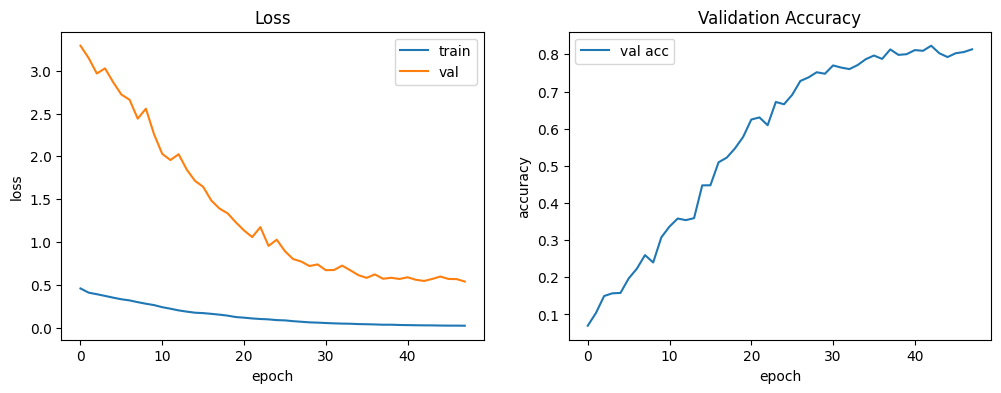

In [64]:
# Training curves (from saved logs) (our train_model returns history)

plot_training_curves(
    history["train_loss"],
    history["val_loss"],
    history["val_acc"]
)

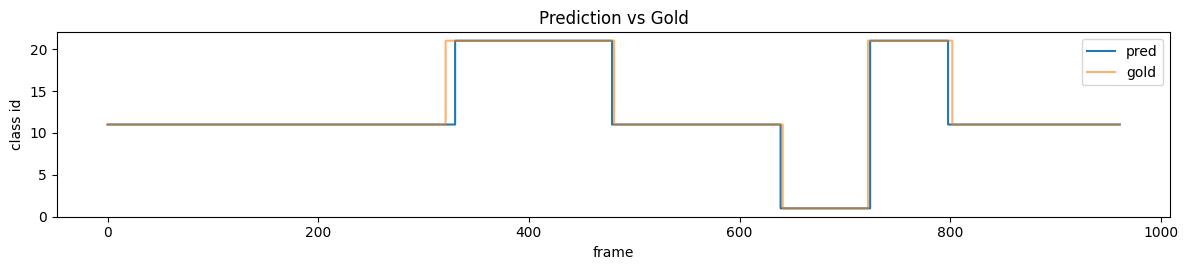

In [69]:
y_true, y_pred, batches = collect_preds_targets(
    model, test_loader, label_enc.classes_,
    device=device,
    decoder="viterbi", decoder_kwargs={"trans_mat": Tmat}
)

batch0 = batches[0]
preds_b, gold_b, pads_b = batch0["preds"], batch0["gold"], batch0["pads"]

b = 1  # pick a sequence in that batch
valid = ~pads_b[b].numpy()
plot_sequence(preds_b[b][valid], gold_b[b][valid], label_enc.classes_)


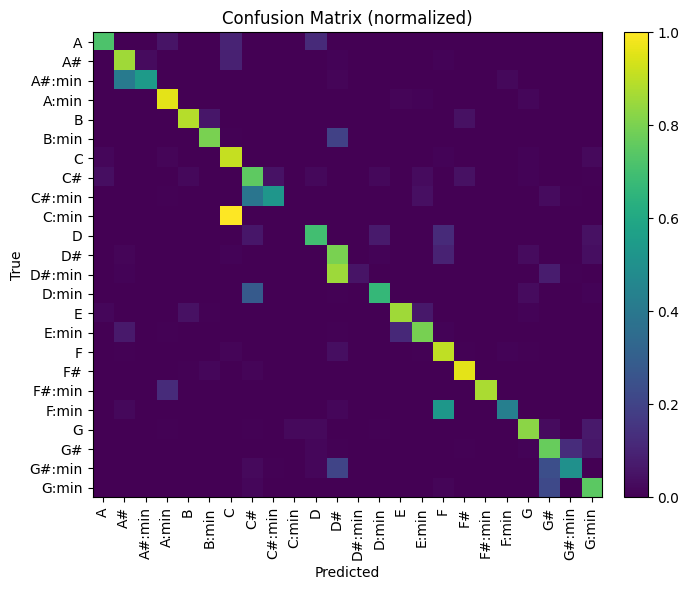

In [78]:
# Confusion matrix (test)
# Use the helper to collect predictions & gold labels (no pads), then plot:

y_true, y_pred, _ = collect_preds_targets(
    model, test_loader, label_enc.classes_,
    device=device,
    decoder="viterbi", decoder_kwargs={"trans_mat": Tmat}  # or "argmax"/"viterbi"
)
# decoder="viterbi", decoder_kwargs={"trans_mat": Tmat}
# decoder="median", decoder_kwargs={"kernel": 9}
plot_confusion(y_true, y_pred, label_enc.classes_, normalize=True)


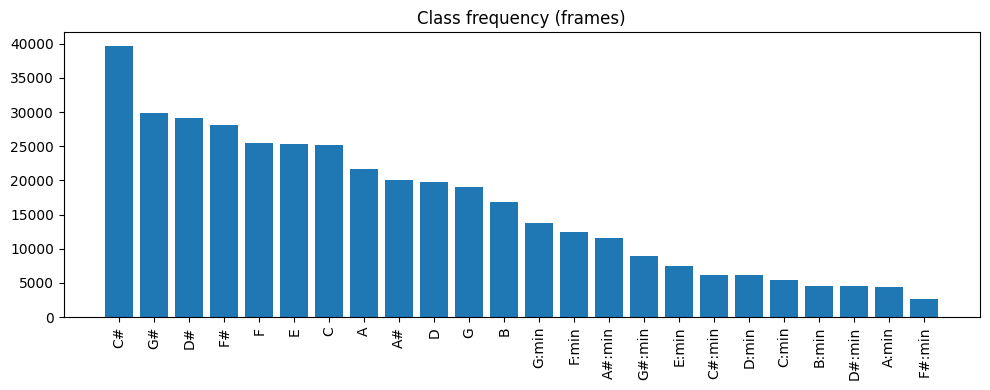

In [71]:
# Class frequency bar (train or test)
# You can swap Y_train with Y_test to visualize test distribution
y_ids = np.concatenate([arr[arr != -100] for arr in Y_train])  # 1-D of ints
plot_class_hist(y_ids, label_enc.classes_, top_k=None)

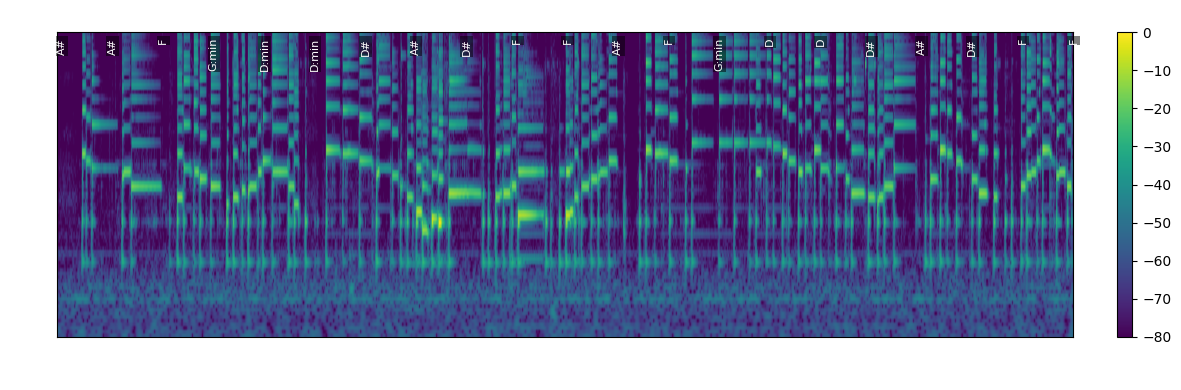

In [76]:
# One pretty CQT+labels for a favorite clip
k = 40  # or your favorite index
C_db  = X_test[k]                  # (F, T)
y_ids = Y_test[k]                  # (T,) integer labels
plot_cqt_with_labels(C_db, y_ids, label_enc.classes_, sr=22050, hop=512, title="CQT + labels")
